In [1]:
from fastai.vision import *
from fastai.callbacks.hooks import *

In [2]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/home/adrian/.fastai/data/camvid/valid.txt'),
 PosixPath('/home/adrian/.fastai/data/camvid/codes.txt'),
 PosixPath('/home/adrian/.fastai/data/camvid/labels'),
 PosixPath('/home/adrian/.fastai/data/camvid/images')]

In [3]:
path_lbl = path/'labels'
path_img = path/'images'

fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/adrian/.fastai/data/camvid/images/0016E5_01020.png'),
 PosixPath('/home/adrian/.fastai/data/camvid/images/Seq05VD_f01110.png'),
 PosixPath('/home/adrian/.fastai/data/camvid/images/0001TP_010170.png')]

In [7]:
path_img

PosixPath('/home/adrian/.fastai/data/camvid/images')

In [8]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/adrian/.fastai/data/camvid/labels/0006R0_f01260_P.png'),
 PosixPath('/home/adrian/.fastai/data/camvid/labels/Seq05VD_f04020_P.png'),
 PosixPath('/home/adrian/.fastai/data/camvid/labels/Seq05VD_f00750_P.png')]

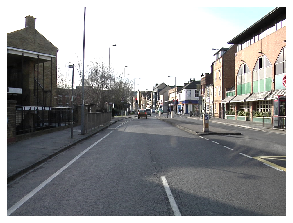

In [9]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))


In [9]:
get_y_fn = lambda x: path_lbl/'{}_P{}'.format(x.stem, x.suffix)

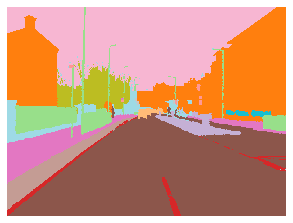

In [16]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [17]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([720, 960]),
 tensor([[[21, 21, 21,  ...,  4,  4,  4],
          [21, 21, 21,  ...,  4,  4,  4],
          [21, 21, 21,  ...,  4,  4,  4],
          ...,
          [10, 10, 10,  ..., 17, 17, 17],
          [10, 10, 10,  ..., 17, 17, 17],
          [10, 17, 17,  ..., 17, 17, 17]]]))

In [4]:
codes = np.loadtxt(path/'codes.txt', dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

array([720, 960])

In [10]:
size = np.array((720, 960)) // 8
#size = src_size//8
batch_size = 8
data = (SegmentationItemList.from_folder(path_img)
        #Where are the images?
        .filter_by_rand(0.05)
       .split_by_fname_file('../valid.txt')
        #How to split in train/valid?
       .label_from_func(get_y_fn, classes=codes)
        #How to find the labels? -> use get_y_func on the file name of the data
       .transform(get_transforms(), size=size, tfm_y=True)
       #Data augmentation? -> Standard transforms; also transform the label images
        .databunch(bs=batch_size, num_workers=0)
        #  we convert to a DataBunch, use a batch size of batch_size,
        .normalize(imagenet_stats))
         

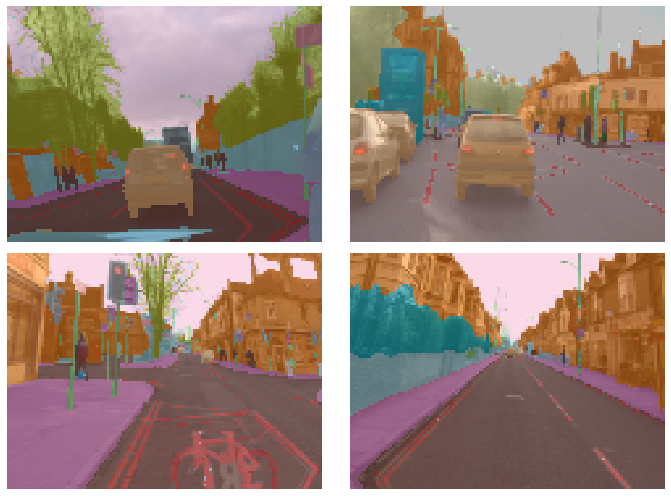

In [22]:
data.show_batch(2, figsize=(10,7))

In [11]:
#The accuracy in an image segmentation problem is the same as that in any classification problem.
#Accuracy = no. of correctly classified pixels / total no. of pixels
# some pixels are labelled as Void and shouldn’t be considered when calculating the accuracy. 
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input_, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input_.argmax(dim=1)[mask]==target[mask]).float().mean()



In [12]:
metrics=acc_camvid
wd=1e-2
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [13]:
lr_find(learn)
#learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [ ]:
#learn.fit_one_cycle(10, slice(1e-06,1e-03), pct_start=0.9)

In [14]:
learn.fit(1)
